#  登堂入室——文本分析实现新闻推荐

## 案例背景
当前，很多网站提供新闻列表，可以令用户方便的查阅自己感兴趣的信息。  

然而，用户浏览新闻，也许仅仅只是随便看到一条。网站的资源非常丰富，可能收藏很多用户感兴趣的其他新闻，但是受限于用户对新闻了解的广泛度，很多新闻用户未能发现，网站也因此错误了很多吸引用户的机会。  

## 任务说明
我们的任务在于，可以根据用户浏览过的新闻，去建立模型，进而可以根据浏览的新闻，与网站现有的其他新闻进行匹配，自动推断出用户最可能感兴趣的新闻，从而达到吸引顾客，防止顾客流失，增加网站流量等目的。

## 扩展联想
该实现可以用于其他推荐的场景，而不限于新闻推荐。例如，音乐，图书，广告等。

## 数据集描述
数据集采用搜狗2012年6月-7月全网新闻数据。该数据集为xml文件格式类型。格式如下：
```xml
<doc>
<url>新闻链接</url>
<docno>新闻编号</docno>
<contenttitle>新闻标题</contenttitle>
<content>新闻内容</content>
</doc>
```

# 程序实现

## 前期准备
本案例需要使用3个库（Anaconda没有预安装），分别为：
* wordcloud
* jieba
* gensim

可以使用如下命令进行安装:  
`pip install wordcloud`  
`pip install jieba`  
`pip install gensim`

## 导入相关的库

In [31]:
import numpy as np
import pandas as pd
import re
import warnings

warnings.filterwarnings("ignore")

## 原始数据的处理
数据集是一个xml类型的文件，我们不能使用pandas直接进行加载。  
我们读取原始的数据集，使用正则表达式提取`<contenttitle>`与`</contenttitle>`中的标题信息。并将信息输入到另外一个文档中。

In [ ]:
re_obj = re.compile(r"<contenttitle>(.+?)</contenttitle>")
re_obj2 = re.compile(r"<content>(.+?)</content>")
with open("news_tensite_xml.dat", encoding="ANSI") as f, open("news.dat", "wt", encoding="ANSI") as f2:
    for line in f:
        match = re_obj.match(line)
        if match:
            f2.write(match.group(1))
            line2 = f.readline()
            match2 = re_obj2.match(line2)
            if match2:
                f2.write(match2.group(1))
            f2.write("\n")

## 加载数据集
加载数据集，并查看数据的基本信息。

In [32]:
news = pd.read_csv(r"news.dat", header=None, names=["title"], encoding="ANSI")

In [33]:
display(news.shape)
display(news.head())
# news.iloc[0].tolist()

(1293605, 1)

,title
0,公安机关销毁１０余万非法枪支 跨国武器走私渐起中广网唐山６月１２日消息（记者汤一亮 庄胜春）...
1,张绍刚发道歉信网友不认可：他的问题是俯视他人（图）天津卫视求职节目《非你莫属》“晕倒门”事件...
2,＃（关注夏收）（３）夫妻“麦客”忙麦收临沂（山东），２０１２年６月４日 夫妻“麦客”忙麦收 ...
3,欧洲杯大战在即 荷兰葡萄牙面临淘汰将背水一战中广网北京６月１３日消息（记者王宇）据中国之声《...
4,扎克伯格携妻罗马当街吃３０元麦当劳午餐（组图）环球网记者李亮报道，正在意大利度蜜月的“脸谱”...


## 数据清洗

### 缺失值处理

In [34]:
news.isnull().sum()

title    0
dtype: int64

### 重复值处理

In [37]:
# news.duplicated().sum()
# news[news.duplicated()]
news.drop_duplicates(inplace=True)
display(news.shape)

(995364, 1)

## 去特殊字符，分词，去除停用词
### 分词

分词是将连续的文本，分割成语义合理的若干词汇序列。我们可以通过jieba来实现分词的功能。

In [38]:
import jieba

s = "今天，外面下了一场很大的雨。@#￥#@。"
# jieba.cut(s)
jieba.lcut(s)

['今天',
 '，',
 '外面',
 '下',
 '了',
 '一场',
 '很大',
 '的',
 '雨',
 '。',
 '@',
 '#',
 '￥',
 '#',
 '@',
 '。']

我们发现，分词会保留标点符号与特殊字符，因此，我们可以在分词前，先将这些内容去除。

### 去除停用词

![图像无法显示](./imgs/exercise.png "课堂练习")
“今天，外面下了一场很大的雨。”最能体现这句话核心含义的词语是什么？  
A 了 的  
B 今天 雨  
C 下 雨  
D 外面 很大
![图像无法显示](./imgs/split_line.png "课堂练习")

停用词，指的是在我们语句中大量出现，但却对语义分析没有帮助的词。对于这样的词汇，我们通常可以将其删除，这样的好处在于：
1. 可以降低存储空间消耗。
2. 可以减少计算时间消耗。

### 综合处理
我们将之前的步骤进行综合处理。

In [ ]:
re_obj = re.compile(r"[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~——！，。？、￥…（）：【】《》‘’“”\s\ue40c]+")

# 获取停用词列表
def get_stopword():
    s = set()
    with open("stopword.txt", encoding="UTF-8") as f:
        for line in f:
            s.add(line.strip())
    return s

stopword = get_stopword()

# 清洗文本数据
def clear(text):
    return re_obj.sub("", text)
    
# 进行分词的函数。
def cut_word(text):
    return jieba.cut(text)

# 去掉停用词函数。
def remove_stopword(words):
    return [word for word in words if word not in stopword]

def preprocess(text):
    text = clear(text)
    word_iter = cut_word(text)
    word_list = remove_stopword(word_iter)
    return word_list

In [39]:
# 因为执行时间较长，这里，我们只取前1000条新闻。
# news = news.iloc[:1000]
news = news.iloc[:10]
news["title"] = news["title"].apply(preprocess)

In [40]:
ord("１"), ord("1")

(65297, 49)

## 文本分析

### 词云图统计

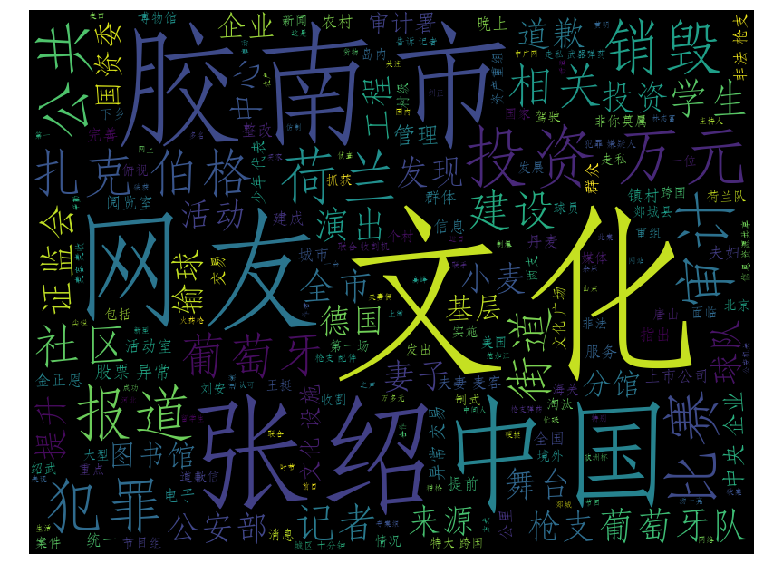

In [41]:
import wordcloud
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
from itertools import chain

mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False

wc = wordcloud.WordCloud(font_path=r"C:/Windows/Fonts/STFANGSO.ttf", width=800, height=600)
li = news["title"].tolist()
li = list(chain.from_iterable(li))
join_words = " ".join(li)
img = wc.generate(join_words)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')
wc.to_file("wordcloud.png")

此外，我们还可以使用指定的图片作为背景，生成词云图。

(-0.5, 1169.5, 965.5, -0.5)

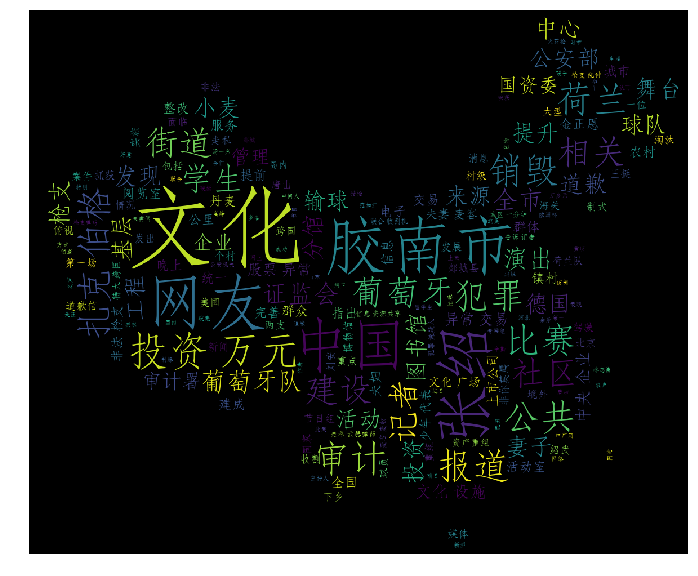

In [42]:
wc = wordcloud.WordCloud(font_path=r"C:/Windows/Fonts/STFANGSO.ttf", mask=scipy.misc.imread("map.jpg"))
img = wc.generate(join_words)
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')

### 数据建模

![图像无法显示](./imgs/exercise.png "课堂练习")
如果需要实现新闻相似度的匹配，我们可以对两条新闻进行分词处理，然后分别比较新闻中出现共同词语的个数。这种做法好吗？  
A 好  
B 不好  
![图像无法显示](./imgs/split_line.png "课堂练习")

In [ ]:
documents = news["title"].tolist()
print(documents[0])

In [43]:
import logging
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

documents = news["title"].tolist()
# doc2vec训练的语料与word2vec的格式有些不同。doc2vec要求语料为TaggedDocument构成的数组。
# TaggedDocument代表的就是一篇文档，该文档包含若干个词汇。

# TaggedDocument的参数。 doc 一维数组，文档中的词汇。 [index] 表示文档的标签。
documents = [TaggedDocument(doc, [index]) for index, doc in enumerate(documents)]
# documents：用来训练的语料。要求是TaggedDocument构成的数组。
# vector_size：文档进行嵌入的维度。（文档映射到空间当中，向量的维度）。
# window：当前词汇与预测词汇之间的最远距离。
# min_count: 考虑最小词频的词汇。（如果词汇低于该词频，则不再考虑该词汇）
# worker：并发的数量。
# epochs：训练的轮数。
model = Doc2Vec(documents, vector_size=32, window=5, min_count=1, workers=4, epochs=40)

2019-06-14 21:44:45,166 : INFO : collecting all words and their counts
2019-06-14 21:44:45,171 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2019-06-14 21:44:45,175 : INFO : collected 1147 word types and 10 unique tags from a corpus of 10 examples and 2043 words
2019-06-14 21:44:45,179 : INFO : Loading a fresh vocabulary
2019-06-14 21:44:45,186 : INFO : effective_min_count=1 retains 1147 unique words (100% of original 1147, drops 0)
2019-06-14 21:44:45,190 : INFO : effective_min_count=1 leaves 2043 word corpus (100% of original 2043, drops 0)
2019-06-14 21:44:45,198 : INFO : deleting the raw counts dictionary of 1147 items
2019-06-14 21:44:45,201 : INFO : sample=0.001 downsamples 43 most-common words
2019-06-14 21:44:45,203 : INFO : downsampling leaves estimated 1911 word corpus (93.6% of prior 2043)
2019-06-14 21:44:45,210 : INFO : estimated required memory for 1147 words and 32 dimensions: 868412 bytes
2019-06-14 21:44:45,211 : INFO : resetting layer

2019-06-14 21:44:55,456 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-06-14 21:44:56,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-06-14 21:44:56,142 : INFO : EPOCH - 15 : training on 2043 raw words (1901 effective words) took 0.7s, 2761 effective words/s
2019-06-14 21:44:56,148 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-06-14 21:44:56,156 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-06-14 21:44:56,163 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-06-14 21:44:56,809 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-06-14 21:44:56,811 : INFO : EPOCH - 16 : training on 2043 raw words (1911 effective words) took 0.7s, 2873 effective words/s
2019-06-14 21:44:56,817 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-06-14 21:44:56,820 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-06-14 2

2019-06-14 21:45:07,226 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-06-14 21:45:07,227 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-06-14 21:45:07,230 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-06-14 21:45:07,905 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-06-14 21:45:07,906 : INFO : EPOCH - 32 : training on 2043 raw words (1914 effective words) took 0.7s, 2812 effective words/s
2019-06-14 21:45:07,914 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-06-14 21:45:07,920 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-06-14 21:45:07,933 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-06-14 21:45:08,641 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-06-14 21:45:08,644 : INFO : EPOCH - 33 : training on 2043 raw words (1917 effective words) took 0.7s, 2623 effective words/s
2019-06-14 2

In [44]:
# documents[0].words
# documents[0].tags
vector = model.infer_vector(documents[0].words)
sim = model.docvecs.most_similar([vector], topn=5)
sim

2019-06-14 21:46:46,061 : INFO : precomputing L2-norms of doc weight vectors


[(0, 0.9338773488998413),
 (7, 0.9074890613555908),
 (8, 0.9061250686645508),
 (4, 0.9053072929382324),
 (3, 0.9050315618515015)]

### 模型效果评估

In [45]:
ranks = []
for doc in documents:
    # doc.words就是一个文档中包含的词汇列表。infer_vector方法的作用是将参数指定的
    # 文档中的词汇列表表示成向量的形式（推断表示）。即如果参数指定的词汇(文档)映射到
    # 当前的模型空间中，应该表示成为怎样的向量。
    inferred_vector = model.infer_vector(doc.words)
    # 根据参数指定的向量，返回当前模型中，与参数向量最相似的向量。
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    # 查看推断文档的向量与自己比较，相似度排行第几。（理想情况下，应该排在最前面）
    rank = [tag for tag, _ in sims].index(doc.tags[0])
    ranks.append(rank)

我们可以输出查看下模型的效果。

In [46]:
from collections import Counter

# Counter([1, 2, 3, 1, 2])
print(Counter(ranks))

Counter({0: 8, 1: 1, 3: 1})


### 模型预测

In [47]:
display(",".join(documents[0].words))
v = model.infer_vector(documents[0].words)
# display(v)
similar = model.docvecs.most_similar([v], topn=3)
for index, score in similar:
    display(score, ",".join(documents[index].words))

'公安机关,销毁,余万,非法,枪支,跨国,武器,走私,渐起,中广网,唐山,月,日,消息,记者,汤一亮,庄胜春据,中国,之声,新闻,晚,高峰,报道,日,上午,公安机关,年缉枪,制爆,专项,统一,销毁,非法,枪爆,物品,活动,河北,唐山,正式,启动,万余只,非法,枪支,余吨,炸药,全国,城市,统一,销毁,黄明,全国,缉枪,制爆,统一,销毁,公安部,副,部长,黄明,一声令下,仿制,式,枪,猎枪,火药枪,气枪,河北,唐山,钢铁厂,投入,炼钢炉,全国,省区市,城市,破案,追缴,群众,主动,上缴,万余支,非法,枪支,销毁,全国,指定,场所,余吨,炸药,销毁,公安部,治安,局局长,刘,绍武,介绍,销毁,非法,枪支,来源于,三个,刘,绍武,打击,破案,包括,涉黑,涉恶,团伙,犯罪,毒品,犯罪,境外,非法,走私,枪支,爆炸物,销毁,现场,记者,追缴,上缴,各式各样,枪支,刘,绍武,包括,制式,枪,军用,枪,仿制,制式,抢,猎枪,私制,火药枪,我国,枪支,管理法,严厉,禁止,非法,持有,中国,世界,持枪,犯罪,犯罪率,最低,国家,中,美,联手,破获,特大,跨国,走私,武器弹药,案,近日,中,美,执法,部门,联手,成功,破获,特大,跨国,走私,武器弹药,案,中国,抓获,犯罪,嫌疑人,名,缴获,各类,枪支,支,子弹,万余,发及,枪支,配件,美国,抓获,犯罪,嫌疑人,名,缴获,各类,枪支,支,公安部,美国移民,海关,执法局,联合,调查,方式,侦破,跨国,案件,成功,案例,年,月,日,上海浦东国际机场,海关,美国纽约,发,浙江,台州,申报,品名,扩音器,音箱,快件,查验,时,发现,货物,藏有,手枪,支,枪支,配件,件,长枪,部件,件,检验,杀伤力,制式,枪支,配件,公安部,海关总署,高度重视,公安部,刑侦局,局长,刘安,成,是从,海关,进口,货物,中,检查,夹带,来源,地是,境外,说,国外,特大,跨国,走私,武器弹药,案件,上海市公安局,上海海关,缉私局,成立,联合,专案组,迅速开展,案件,侦查,专案组,月,日,浙江,台州,Ｕ,Ｐ,Ｓ,取件,处,犯罪,嫌疑人,王挺,男,岁,台州市,抓获,王挺,交代,境外,网站,上家,林志富,年,月,林志富,长期,居住,美国,互联网,组建,走私,贩卖,私藏枪支,弹药,群体,网络,国内,寻找,枪支弹药,买家,美国,Ｕ,Ｐ,Ｓ,联邦,速递,公司,枪支弹药,纽约,递给

0.9351756572723389

'公安机关,销毁,余万,非法,枪支,跨国,武器,走私,渐起,中广网,唐山,月,日,消息,记者,汤一亮,庄胜春据,中国,之声,新闻,晚,高峰,报道,日,上午,公安机关,年缉枪,制爆,专项,统一,销毁,非法,枪爆,物品,活动,河北,唐山,正式,启动,万余只,非法,枪支,余吨,炸药,全国,城市,统一,销毁,黄明,全国,缉枪,制爆,统一,销毁,公安部,副,部长,黄明,一声令下,仿制,式,枪,猎枪,火药枪,气枪,河北,唐山,钢铁厂,投入,炼钢炉,全国,省区市,城市,破案,追缴,群众,主动,上缴,万余支,非法,枪支,销毁,全国,指定,场所,余吨,炸药,销毁,公安部,治安,局局长,刘,绍武,介绍,销毁,非法,枪支,来源于,三个,刘,绍武,打击,破案,包括,涉黑,涉恶,团伙,犯罪,毒品,犯罪,境外,非法,走私,枪支,爆炸物,销毁,现场,记者,追缴,上缴,各式各样,枪支,刘,绍武,包括,制式,枪,军用,枪,仿制,制式,抢,猎枪,私制,火药枪,我国,枪支,管理法,严厉,禁止,非法,持有,中国,世界,持枪,犯罪,犯罪率,最低,国家,中,美,联手,破获,特大,跨国,走私,武器弹药,案,近日,中,美,执法,部门,联手,成功,破获,特大,跨国,走私,武器弹药,案,中国,抓获,犯罪,嫌疑人,名,缴获,各类,枪支,支,子弹,万余,发及,枪支,配件,美国,抓获,犯罪,嫌疑人,名,缴获,各类,枪支,支,公安部,美国移民,海关,执法局,联合,调查,方式,侦破,跨国,案件,成功,案例,年,月,日,上海浦东国际机场,海关,美国纽约,发,浙江,台州,申报,品名,扩音器,音箱,快件,查验,时,发现,货物,藏有,手枪,支,枪支,配件,件,长枪,部件,件,检验,杀伤力,制式,枪支,配件,公安部,海关总署,高度重视,公安部,刑侦局,局长,刘安,成,是从,海关,进口,货物,中,检查,夹带,来源,地是,境外,说,国外,特大,跨国,走私,武器弹药,案件,上海市公安局,上海海关,缉私局,成立,联合,专案组,迅速开展,案件,侦查,专案组,月,日,浙江,台州,Ｕ,Ｐ,Ｓ,取件,处,犯罪,嫌疑人,王挺,男,岁,台州市,抓获,王挺,交代,境外,网站,上家,林志富,年,月,林志富,长期,居住,美国,互联网,组建,走私,贩卖,私藏枪支,弹药,群体,网络,国内,寻找,枪支弹药,买家,美国,Ｕ,Ｐ,Ｓ,联邦,速递,公司,枪支弹药,纽约,递给

0.909044623374939

'国资委,回应,央企,审计报告,称,修改,中新社,北京,月,日电,记者,刘辰瑶,国资委,日,官,网上,回应,日前,国家审计署,发布,家,中央,企业,年,财务收支,审计,公告,社会,对央企,监督,点名,央企,日前,纷纷,审计署,提出,检讨,并称,进一步,完善,制度,审计署,日,公布,中,石油,中石化,中国,电科,一汽,二重,家,中央,企业,年度,财务收支,审计,公告,披露,中央,企业,财务管理,内部,管理,投资,项目管理,审计署,指出,中国,农业,发展,集团,所属,企业,发车,补贴,两千余,万元,中农,发,审计,发现,审边,改,纠正,中,石油,集团,官网,发出,声明,年,会计,决算,工作,完善,相关,制度,工作,流程,限期,整改,提交,整改,报告,中石化,源头,及时发现,堵塞,漏洞,几家,企业,官网,做出,程度,检讨,审计署,企业,审计,司,负责人,名,相关,责任人,严肃处理,局级,干部,对此,国资委,指出,相关,企业,修订,完善,项,规章制度,审计,中,发现,已有,整改,整改,中,国资委,称,审计,中,发现,值得,关注,年,审计署,公布,审计,评价,意见,中央,企业,改革,发展,依旧,很大,成绩,经营,管理水平,有所提高,国资委,审计报告,发布,契机,督促,相关,企业,认真落实,审计,整改意见,剖析,原因,风险,管控,堵塞,管理,漏洞,规范,管理,中央,企业,紧密结合,管理,提升,活动,夯实,基础,管理,建立,长效机制'

0.9076588153839111

'证监会,重组,中,股票,异常,交易,监管,证监会,近日,新闻,通气会,上市公司,资产重组,相关,股票,异常,交易,监管,暂行规定,征求意见,稿,社会,公开,征求意见,上市公司,停牌,资产重组,程序,证券,交易所,启动,股票,异常,交易,核查,程序,股票,异常,交易,信息,上报,证监会,证监会,股票,异常,交易,信息,核查,涉嫌,内幕,交易,立案,稽查,上市公司,应,暂停,重组,进程,信息,披露,风险,提示,上市公司,控股,股东,控制,占,本次,重组,总,交易额,比例,交易,本次,资产重组,相关,内幕,交易,证监会,行政处罚,司法机关,依法追究,刑事责任,证监会,终止,审核,记者,李会,来源,经济日报'

### 词嵌入可视化

In [48]:
from sklearn.manifold import TSNE

# 进行降维，参数指定降维的维数。
tsne = TSNE(n_components=2)
# 获取所有词汇标签。
y = list(model.wv.vocab.keys())
# 取部分词汇标签，进行可视化展示。
y = y[:30]
# 根据词获取嵌入向量。
X = model.wv[y]
# 进行降维转换。
X_tsne = tsne.fit_transform(X)

In [49]:
X_tsne.shape

(30, 2)

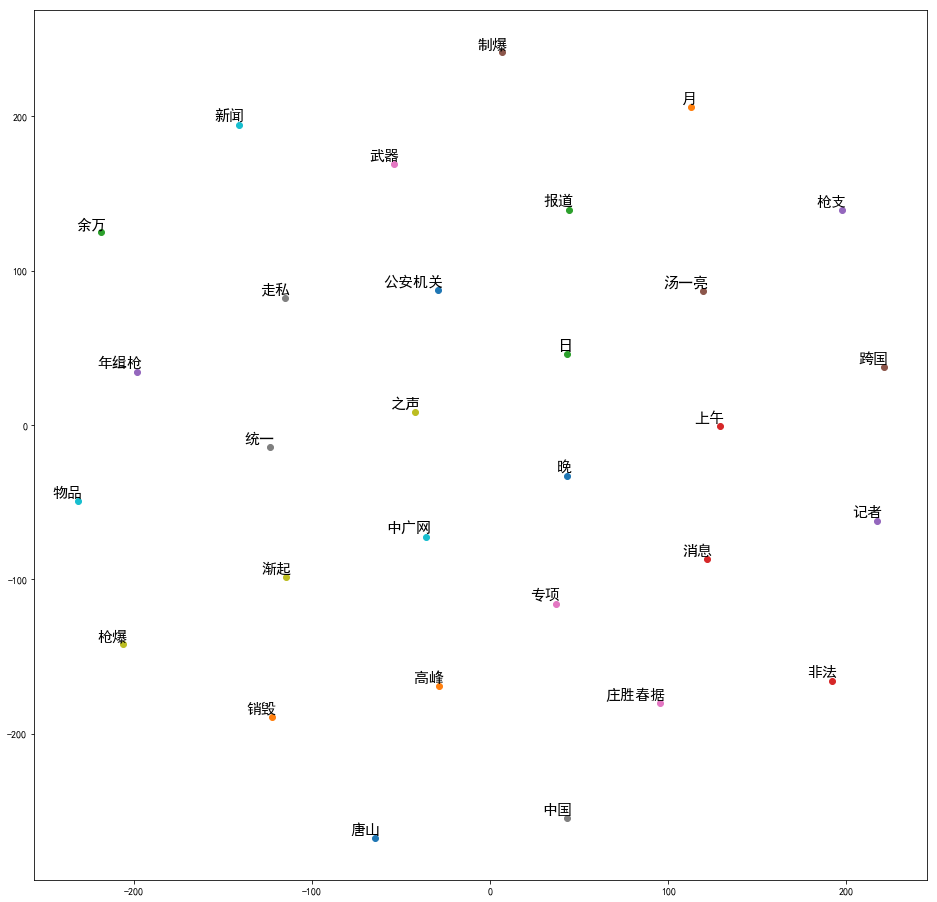

In [50]:
plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    # 在散点上打上标签（单词的文本）
    plt.annotate(y[i], fontsize=15,
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()